# First Machine Learning Excercise: Facies classification 

In this exercise (simplified with respect to the original) extracted from [Hall et al. (2016), The Leading Edge](https://library.seg.org/doi/full/10.1190/tle35100906.1) we aim to use machine learning to predict facies from well log data. The dataset is realted to the largest gas field in Southwestern Kansas (US). In this excercise we will use log data from nine wells that have been labeled with a facies type based on oberservation of cores and we will use a ML model to classify facies types.  

## Introduction to Scikit Learn
Scikit-learn libray objects can be subdivided in:

##### Transformers 
Any object that transform a dataset. Transformations are performed by the `transform()` method with the dataset to transform as parameter 

```python 
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)
```

##### Estimators 
Any object that can estimate some parameters based on the dataset. It is generally perfomed by the method `fit()` and it takes only one or two (for supervised learning) data variables as inputs.

"Here it is the Support Vector Machines (svm)"

```python 
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,y_train)
```

##### Predictors 
Any object that given a trained estimator that is capable to make predictions on new data. A predictor object has a  `predict()` method that receives data as input and returns the corresponding predictions. Predictors have also a 
`score()` method that can be used to evaluate the performance of the ML model.

```python
predicted_labels = clf.predict(X_test)
clf.score(X_test,y_test) 
```

## Reading the dataset
This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables (geophysical logs and geologic data) and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at about 15 cm intervals.

First, we will examine the data set we will use to train the classifier. The training data is contained in the file `facies_vectors.csv`, that contains 5 wireline log measurements, two indicator variables and a facies label at half foot intervals (approximately 15 cm).  Eeach log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data from 9 wells into a dataframe, which provides a convenient data structure to work with such data. Then we will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

In [2]:
import pandas as pd
from pandas import set_option
set_option("display.max_rows", 25)

pd.options.mode.chained_assignment = None

filename = 'facies_vectors.csv'
well_data = pd.read_csv(filename)
well_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


## Exploring the Dataset
Here we describe how the dataset is structured.
The feature vectors consist of the following variables:

1) Gamma ray (GR)
2) Resistivity (ILD_log10)
3) Photoelectric effect (PE)
4) Neutron-density porosity difference (DeltaPHI) 
5) Average neutron-density porosity (PHIND)
6) Nonmarine/marine indicator (NM_M)
7) Relative position (RELPOS)

Facies (classes of rocks) are denoted by integer numbers and denoted in the following way:
Class Label. Facies Name, Label

1) Nonmarine sandstone, SS
2) Nonmarine coarse siltstone, CSiS 
3) Nonmarine fine siltstone, FSiS
4) Marine siltstone and shale, SiSh 
5) Mudstone (limestone), MS
6) Wackestone (limestone), WS
7) Dolomite, D
8) Packstone-grainstone (limestone), PS
9) Phylloid-algal bafflestone (limestone), BS

## Organinzing and Visualizing the Dataset
Now we need to split the dataset into training and test data. Here we do that by removing a single well that we will use for a `blind_test` later.

In [3]:
blind_test = well_data[well_data['Well Name'] == 'SHRIMPLIN']
training = well_data[well_data['Well Name'] != 'SHRIMPLIN']

training['Well Name'] = training['Well Name'].astype('category')
training['Formation'] = training['Formation'].astype('category')
training['Well Name'].unique()

['ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (9, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NEWBY', 'NOLAN', 'Recruit F9', 'SHANKLE']

Before plotting data, we define a color map for the facies that will help us when visualizing the dataset. The dictionary `facies_color_map` maps facies labels to their respective colors and using the list of facies labels as keys.

In [4]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D','PS', 'BS']
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training.loc[:,'FaciesLabels'] = training.apply(lambda row: label_facies(row, facies_labels), axis=1)
training.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000,2761.000000,3678.000000,3678.000000
mean,4.518488,2906.402121,64.360933,0.659551,3.979120,13.332628,3.640581,1.522295,0.522795
std,2.506355,139.467190,29.242750,0.255159,5.241096,7.323132,0.867410,0.499571,0.286269
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2811.625000,44.381750,0.500000,1.321000,8.550000,3.084000,1.000000,0.279000
50%,4.000000,2936.000000,64.740000,0.643000,3.900000,11.991500,3.500000,2.000000,0.528500
75%,7.000000,3013.500000,78.645000,0.821000,7.000000,16.153750,4.200000,2.000000,0.769000
max,9.000000,3138.000000,305.870000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables. Looking at the `count` values, most values have almost the same number of valid values except for `PE`.  Here we will drop the feature vectors that don't have a valid `PE` entry.

In [5]:
PE_mask = training['PE'].notnull().values
training= training[PE_mask]

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class this is usefult to check if we have a class imbalance problem. We count the number of unique entries for each facies, and sort them by facies number (instead of by number of entries), we then use facies labels to index each count.

<AxesSubplot:title={'center':'Facies data distribution'}>

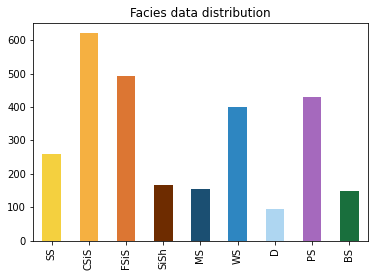

In [7]:
facies_counts = training['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, title='Facies data distribution')

This shows the distribution of examples by facies for the training examples in the training set.  Dolomite (facies D) has the fewest examples. Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

We are now goint to use a crossplot to visualize how a variable of the dataset changes with respect to the other ones. This dataset contains 5 log measurement data, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.

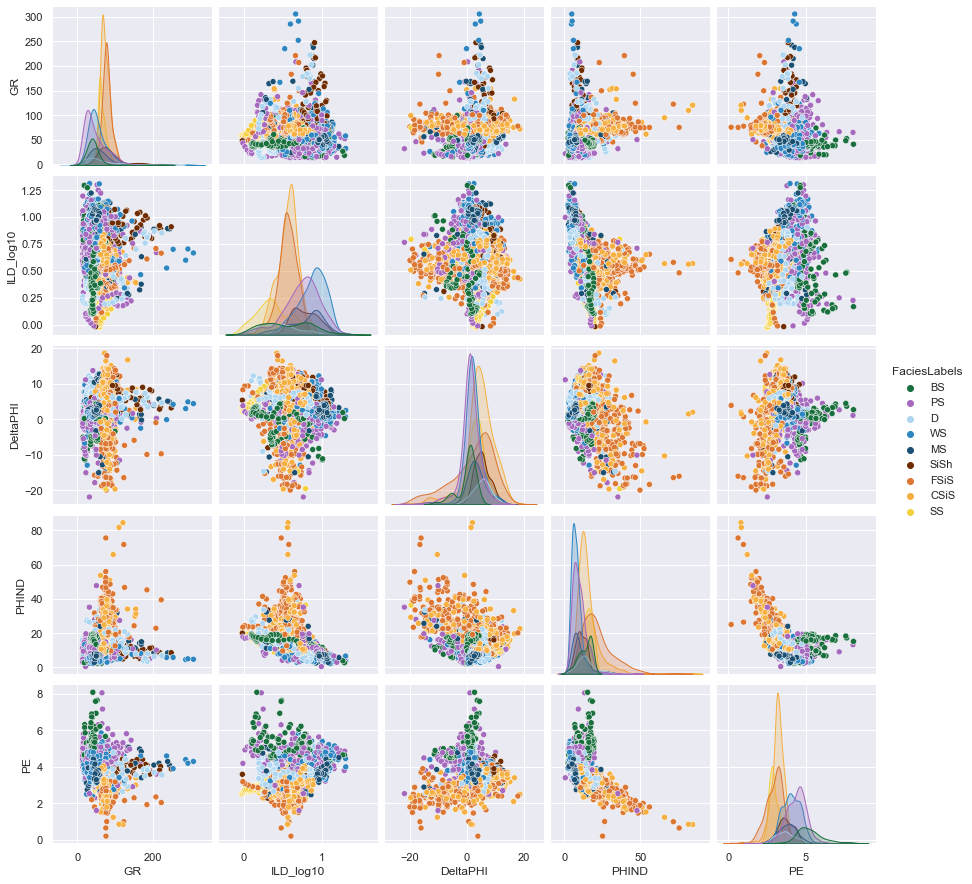

In [6]:
import seaborn as sns
sns.set()
sns.pairplot(training.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

## Scaling the dataset
 We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance (standardization). We will also split the data into training and test sets. We also extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [7]:
correct_facies_labels = training['Facies'].values
feature_vectors = training.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000
mean,65.577405,0.639826,2.851888,13.706603,3.640581,1.500181,0.521278
std,29.587629,0.243261,5.044868,8.014523,0.867410,0.500091,0.286324
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.923000,0.493000,0.800000,8.412000,3.084000,1.000000,0.276000
50%,65.360000,0.627366,2.991000,12.128000,3.500000,2.000000,0.528000
75%,78.820000,0.810000,5.800000,16.710000,4.200000,2.000000,0.768000
max,305.870000,1.311000,18.600000,84.400000,8.094000,2.000000,1.000000


The Scikit-learn library includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data, the `StandardScalar` class, that gives each variable zero mean and unit variance.  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.   can be fit to the training set, and later used to standardize any training data.

In [8]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [9]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,98.360,0.642,-0.100,18.685,2.900,1,1.000
938,97.570,0.631,7.900,16.745,3.200,1,0.984
939,98.410,0.615,12.800,14.105,3.200,1,0.968
940,85.920,0.597,13.000,13.385,3.400,1,0.952
941,83.160,0.592,12.300,13.345,3.400,1,0.935
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit also includes a function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

## Training our first Machine Learning Algorithm

After data are ready to be used. We use a Support Vector Machine (SVM) method to perform the classification (at the moment you do not need to know how it works). The SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) requires different parameters that can be tuned to obtain the best results, but for now let use the default settings.  

In [11]:
from sklearn import svm

clf = svm.SVC()

Now we can train the classifier using the training set we created above.

In [12]:
clf.fit(X_train,y_train)

SVC()

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

In [13]:
predicted_labels = clf.predict(X_test)

We need some metrics to evaluate how good our classifier is doing, here we use the [accuracy-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) implemented in scikit.

In [14]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_test, predicted_labels)  #do you understand the difference between this
scr=clf.score(X_test,y_test) # and this

print('Facies classification accuracy = %f'%accuracy)
print('Facies classification score = %f'%scr)


Facies classification accuracy = 0.587703
Facies classification score = 0.587703


The accuracy is defined as the number of correct classifications divided by the total number of classifications (we will see later that we cna use different quality metrics).

## Hyper-parameters Optimization

In the previous example the classifier has been used with default parameters. We can get better results if we tune the so called hyper-parameters. In this case our SVM classifier requires two parameters that we need to tune,  `C`  and `gamma`. 

The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The `gamma` parameter describes the size of the `radial basis functions` (the kernel of our SVM classifier), which is how far away two vectors in the feature space need to be to be considered close.

The process of tuning the Hyper-parameters is also known as 'cross validation'. Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection. Here you can use the test set to choose model parameters. 

## Now your turn!!!

Excercise 1
Try to find the best `C` and `gamma` values to improve the classification.
`C` values may range from 0 to 20 with step 1
`gamma` values may range from 0.5 to 2.0 with step 0.1
Evaluate the improvement of your classificator

Hint: 
```python
    def hypopt(c_values, g_values):
         ...
         clf = svm.SVC(C=c_value, gamma=c_value)
         ...
         return opt_accuracy, c_best, g_best
```

Excercise 2
Apply the classification model to the blind data stored within the dataframe called `blind_test`